# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [103]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy.stats
import cProfile
import pstats
import os
import time
from pstats import SortKey

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baseline
* Tree analysis includes initial guess optimization -- at the root node.
* No coarsening, best solving performance, slowest runtime.

In [37]:
slot_values = np.arange(5, 9, dtype=int)

In [38]:
tree_by_slots = {}
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    tree_file = "db/nerdle{}_tree.pkl".format(num_slots) 
    if os.path.exists(tree_file):
        print("Loading tree")
        with open(tree_file, 'rb') as f:
            tree = pickle.load(f)
    else:
        print("Building tree")
        %time tree = analysis.GameTreeBuilder(solver_data).build()
        with open(tree_file, 'wb') as f:
            pickle.dump(tree, f)
    tree_by_slots[num_slots] = tree

num_slots 5
Loading tree
num_slots 6
Loading tree
num_slots 7
Loading tree
num_slots 8
Loading tree


In [121]:
def solve_stats(tree, min_num_guesses: int = 2, max_num_guesses: int = 5):
    tdc = analysis.TreeDepthCalculator(tree)
    # Distribution of #guesses for all answers.
    num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
    num_leaves = sum(1 for node in tdc.depth if not node.children)
    freq = collections.Counter(num_guesses)
    freq = [freq[k] / num_leaves if k in freq else 0 for k in range(min_num_guesses, max_num_guesses+1)]
    info = [
        ("mean", np.mean(num_guesses)),
        ("std", np.std(num_guesses)),
        ("initial guess", tree.key[1]), 
        ("bucket size", tree.key[2]), 
        ("nodes", len(tdc.depth)),
        ("leaves",  num_leaves),
        ("max",  max(num_guesses)), 
    ] + list(zip(range(min_num_guesses, max_num_guesses+1), freq))
    return info

In [122]:
min_num_guesses, max_num_guesses = 2, 5
info = [[("num_slots", num_slots)] + solve_stats(tree_by_slots[num_slots], min_num_guesses=min_num_guesses, max_num_guesses=max_num_guesses) 
        for num_slots in slot_values]
info = pd.concat([pd.DataFrame([[x[1] for x in i]], columns=[x[0] for x in i]) for i in info])
info

,num_slots,mean,std,initial guess,bucket size,nodes,leaves,max,2,3,4,5
0,5,3.617512,0.933882,1+2=3,42,286,217,5,0.087558,0.437788,0.244240,0.230415
0,6,2.859223,0.374668,3*8=24,10,250,206,4,0.150485,0.839806,0.009709,0.000000
0,7,3.398889,0.518275,24-16=8,158,9363,7561,4,0.014416,0.572279,0.413305,0.000000
0,8,3.289342,0.489134,58-46=12,101,21593,17723,4,0.016814,0.677030,0.306156,0.000000


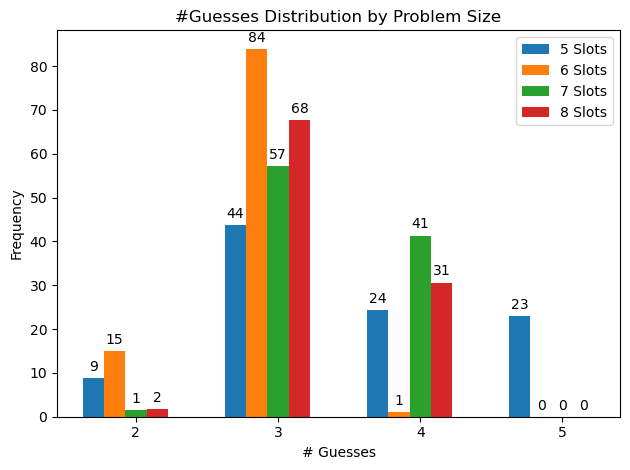

In [145]:
freq_by_slots = [100 * np.array([info.loc[info['num_slots'] == num_slots][g].item() for g in range(min_num_guesses, max_num_guesses + 1)])
                 for num_slots in slot_values]
labels = list(map(str, range(min_num_guesses, max_num_guesses+1)))

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects = [None] * num_slots
for i, num_slots in enumerate(slot_values):
    rects[i] = ax.bar(x + (i - 0.5 * len(slot_values)) * width, freq_by_slots[i], width, label='{} Slots'.format(num_slots))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('# Guesses')
ax.set_ylabel('Frequency')
ax.set_title('#Guesses Distribution by Problem Size')
ax.set_xticks(x, labels)
ax.legend()
for i in range(len(slot_values)):
    ax.bar_label(rects[i], labels=["{:.0f}".format(x) for x in freq_by_slots[i]], padding=3)
#for rect in rects:
#    ax.bar_label(rect, padding=3)
fig.tight_layout()
plt.show()

In [142]:
info.loc[info['num_slots'] == 5][2].item()

0.08755760368663594

* It seems like odd-size Nerdle is harder than even-size! Larger average #guesses.
* Diversifying symbols of initial guess is a generally good criterion.

## Coarsening in Guesses

In [146]:
info = []
guess_coarsening_factor_values = (1, 2, 4, 8, 16)
for num_slots in slot_values:
    for guess_coarsening_factor in guess_coarsening_factor_values:
        print("num_slots", num_slots, "guess_coarsening_factor", guess_coarsening_factor)
        db_file = "db/nerdle{}.db".format(num_slots) 
        solver_data = nerdle.create_solver_data(num_slots, db_file)
        t = time.time()
        tree = analysis.GameTreeBuilder(solver_data).build(guess_coarsening_factor=guess_coarsening_factor)
        t = time.time() - t
        #guess_coarsening[num_slots] = tree
        info.append(solve_stats(tree, min_num_guesses=min_num_guesses, max_num_guesses=max_num_guesses) + \
            [("time", t), ("num_slots", num_slots), ("guess_coarsening_factor", guess_coarsening_factor)])
info = pd.concat([pd.DataFrame([[x[1] for x in i]], columns=[x[0] for x in i]) for i in info])

num_slots 5 guess_coarsening_factor 1
num_slots 5 guess_coarsening_factor 2
num_slots 5 guess_coarsening_factor 4
num_slots 5 guess_coarsening_factor 8
num_slots 5 guess_coarsening_factor 16
num_slots 6 guess_coarsening_factor 1
num_slots 6 guess_coarsening_factor 2
num_slots 6 guess_coarsening_factor 4
num_slots 6 guess_coarsening_factor 8
num_slots 6 guess_coarsening_factor 16
num_slots 7 guess_coarsening_factor 1
num_slots 7 guess_coarsening_factor 2
num_slots 7 guess_coarsening_factor 4
num_slots 7 guess_coarsening_factor 8
num_slots 7 guess_coarsening_factor 16
num_slots 8 guess_coarsening_factor 1
num_slots 8 guess_coarsening_factor 2
num_slots 8 guess_coarsening_factor 4
num_slots 8 guess_coarsening_factor 8
num_slots 8 guess_coarsening_factor 16


In [147]:
info

,mean,std,initial guess,bucket size,nodes,leaves,max,2,3,4,5,time,num_slots,guess_coarsening_factor
0,3.617512,0.933882,1+2=3,0.193548,286,217,5,0.087558,0.437788,0.244240,0.230415,0.079155,5,1
0,3.668203,0.945790,1+2=3,0.193548,290,217,5,0.087558,0.405530,0.258065,0.248848,0.061826,5,2
0,3.691244,0.989142,1+2=3,0.193548,291,217,6,0.087558,0.410138,0.244240,0.239631,0.046171,5,4
0,3.751152,1.052892,1+2=3,0.193548,296,217,7,0.087558,0.387097,0.262673,0.221198,0.036272,5,8
0,3.829493,1.125104,1+2=3,0.193548,301,217,7,0.087558,0.354839,0.304147,0.156682,0.033295,5,16
0,2.859223,0.374668,3*8=24,0.048544,250,206,4,0.150485,0.839806,0.009709,0.000000,0.047689,6,1
0,2.859223,0.374668,3*8=24,0.048544,250,206,4,0.150485,0.839806,0.009709,0.000000,0.039321,6,2
0,2.859223,0.374668,3*8=24,0.048544,250,206,4,0.150485,0.839806,0.009709,0.000000,0.028553,6,4
0,2.859223,0.374668,3*8=24,0.048544,250,206,4,0.150485,0.839806,0.009709,0.000000,0.022562,6,8
0,2.878641,0.406059,3*8=24,0.048544,252,206,4,0.150485,0.820388,0.029126,0.000000,0.022525,6,16


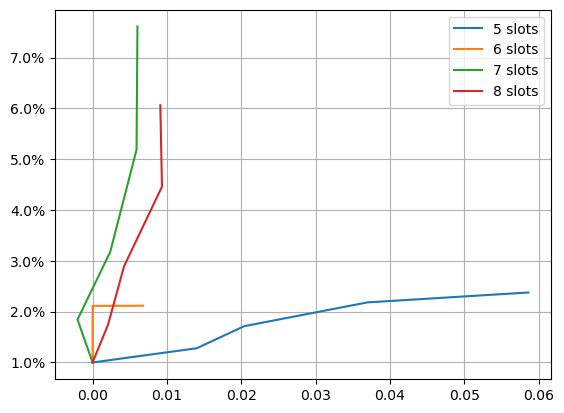

In [169]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
for num_slots in slot_values:
    d = info.loc[info['num_slots'] == num_slots]
    ax.plot((d['mean'].values - d['mean'].values[0]) / d['mean'].values[0], d['time'].values[0] / d['time'].values,
             label="{} slots".format(num_slots));
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True);
ax.legend();

## Multilevel Sampling Max Bucket Estimation

In [ ]:
tree_by_slots_ml = {}
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    tree_file = "db/nerdle{}_tree_ml.pkl".format(num_slots) 
    if os.path.exists(tree_file):
        print("Loading tree")
        with open(tree_file, 'rb') as f:
            tree = pickle.load(f)
    else:
        print("Building tree")
        %time tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel")
        with open(tree_file, 'wb') as f:
            pickle.dump(tree, f)
    tree_by_slots_ml[num_slots] = tree

## Profiling

In [124]:
num_slots = 8
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

num_slots 8


In [123]:
# cProfile.run('tree = analysis.GameTreeBuilder(solver_data, max_answers=2000).build()', 'stats')
# p = pstats.Stats('stats')
# p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

In [65]:
# cProfile.run('tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel", sample_factor=1.5)', 'stats')
# p = pstats.Stats('stats')
# p.sort_stats(SortKey.CUMULATIVE).print_stats(20)

In [9]:
# scipy.stats.mode has a larger overhead than Counter.most_common(), but is faster for large arrays.
for rows in (1000, 10000):
    for cols in (5, 250, 500):
        a = np.random.randint(10, size=(rows, cols))
        r1 = %timeit -r 1 -o -q min(collections.Counter(row).most_common(1)[0][1] for row in a);
        r2 = %timeit -r 1 -o -q min(scipy.stats.mode(a, axis=1, keepdims=False)[1]);
        print(rows, cols, r1.all_runs[0], r2.all_runs[0])

1000 5 0.3496340000128839 0.20788274297956377
1000 250 0.294898482010467 0.2633685609907843
1000 500 0.5520167700015008 0.3147114369785413
10000 5 0.36427297300542705 0.20441173799918033
10000 250 0.2902718990226276 0.26729287300258875
10000 500 0.5486853229813278 0.3630345569981728


In [131]:
# Multilevel starts spaying off around n = 2000 columns.
quantity = lambda a: analysis.max_bucket_sizes(a) / a.shape[1]

for n in ( d.shape[1], ): # 2000, 4000, 6400, 12800,
    print(n)
    a = d[:, :n]

    r = %timeit -o -r 1 -q b = analysis.max_bucket_sizes(a) / a.shape[1]
    print(min(b), np.argmin(b), "time", r.timings[0])

    r = %timeit -o -r 1 -q approx = analysis.min_biased_multilevel_sampling(a, quantity, sample_factor=1.5, debug=True)
    print(min(approx), np.argmin(approx), r.timings[0])

17723
0.020285714285714285 1563 time 11.021933993004495
#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6750 = 14951250
#rows 1107 x sample_size 10125 = 11208375
#rows 553 x sample_size 15187 = 8398411
#rows 276 x sample_size 17723 = 4891548
#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6750 = 14951250
#rows 1107 x sample_size 10125 = 11208375
#rows 553 x sample_size 15187 = 8398411
#rows 276 x sample_size 17723 = 4891548
0.020285714285714285 1563 13.709664375986904


In [129]:
a = d[:, :6000]
cProfile.run('analysis.min_biased_multilevel_sampling(a, quantity, sample_factor=1.5, debug=True)', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(30)

#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6000 = 13290000
Wed Sep 21 10:33:37 2022    stats

         1230483 function calls (1130779 primitive calls) in 9.473 seconds

   Ordered by: cumulative time
   List reduced from 131 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.473    9.473 {built-in method builtins.exec}
        1    0.000    0.000    9.472    9.472 <string>:1(<module>)
        1    2.956    2.956    9.472    9.472 /Users/olivne/oren/nerdle-solver/analysis.py:95(min_biased_multilevel_sampling)
        4    0.000    0.000    6.514    1.628 /var/folders/3k/z6rf4cwj2b1bs57qshd9j_k4fbwv1r/T/ipykernel_94409/384655824.py:2(<lambda>)
        4    0.000    0.000    6.514    1.628 /Users/olivne/oren/nerdle-solver/analysis.py:88(max_bucket_sizes)
        4    0.079    0.020    6.513    1.628 

0.07419653484988759 7561 3786 969


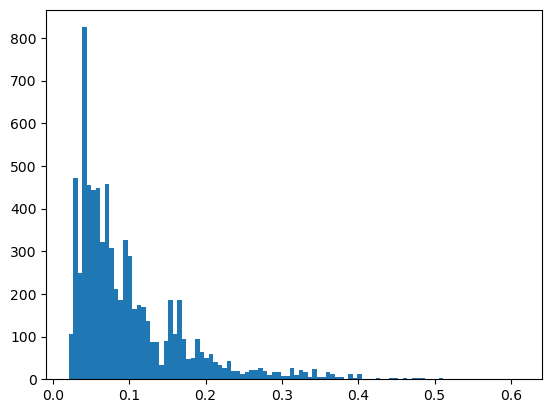

In [51]:
b_median = np.median(b)
print(b_median, len(b), len(np.where(b <= b_median)[0]), len(np.unique(b)))
plt.hist(b, bins=100);

In [97]:
# num_slots = 7
# print("num_slots", num_slots)
# db_file = "db/nerdle{}.db".format(num_slots) 
# solver_data = nerdle.create_solver_data(num_slots, db_file)
# d = solver_data.score_db

# %time tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel")

In [6]:
num_slots = 6
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

tree = analysis.GameTreeBuilder(solver_data).build(debug=True)

num_slots 6
 Node[key=(87, '3*8=24', 0.04854368932038835), guesses=206 answers=206, score=(206, 206), children=73]
	 Node[key=(145, '6*9=54', 0.1111111111111111), guesses=206 answers=9 [  0 129 130 147 151 169 197 202 203], score=(206, 9), children=9]
		 Node[key=None, guesses=58 answers=1 [0], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [129], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [130], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [147], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [151], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [169], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [197], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [202], score=(58, 1), children=0]
		 Node[key=None, guesses=58 answers=1 [203], score=(58, 1), children=0]
	 Node[key=(44, '15-6=9', 0.1111111111111111), guesses=206 answers=9 [ 1  5  9 15 16 44 47 50

ValueError: Failed to solve game